# Source Code Analysis

## Initialization

In [ ]:
import os
import sys

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)
        sys.path.append(path)
# add_path('/home/jjian03/anaconda3/lib/python3.7/site-packages')
# add_path(f'{os.path.abspath(os.path.join("."))}/lib')


### Load Data

In [ ]:
import time
import datetime
import pandas as pd

seed = 77

data_file = 'untrunc_data_cleaned.csv'

raw_data = pd.read_table(data_file, sep=',', index_col=0)
raw_data = raw_data.dropna()

raw_data.info()

print(f'raw_data: {raw_data.shape}')

### Train Test Split

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


x = raw_data.drop(['label', 'first_appear'], axis=1)
y = raw_data.label
y = preprocessing.StandardScaler().fit_transform(y.values.reshape(-1, 1))
y = pd.DataFrame(y).iloc[:,0]


X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.33, random_state=seed)

In [4]:
import gc
import multiprocessing

import warnings
warnings.filterwarnings("ignore")


cpu_cnt = multiprocessing.cpu_count()
allocated_cpu = cpu_cnt
print(f"Allocated {allocated_cpu} CPUs")
gc.collect()

Allocated 16 CPUs


20

#### L-BFGS-B

In [6]:
from concurrent.futures.thread import ThreadPoolExecutor

from sklearn.model_selection import GridSearchCV

from Toolbox import ParameterGenerator
from tobit import *


start_time = time.time()

p_censor_left = -math.inf
p_censor_right = max(y)


param_tr = {
    'C': [0, *np.logspace(-3, 0, 11), *np.arange(1, 10, 1)],
    'alpha': [*np.arange(0.1, 1.05, 0.05)],
}

print(param_tr['C'])

performance_matrix = pd.DataFrame(columns=['lambda', 'alpha', 'intercept', *x.columns, 'log(sigma)'])
C = [0, *np.logspace(-3, 0, 5)]

for idx, param in ParameterGenerator.create_combination_matrix(param_tr).iterrows():
    tr = TobitRegressor(
        p_censor_left=p_censor_left,
        p_censor_right=p_censor_right,
        C=param.C,
        alpha=param.alpha,
#         verbose=True,
    )
    grid = GridSearchCV(
        n_jobs=allocated_cpu,
        cv=5,
        estimator=tr,
        param_grid={
            'C': [param.C],
            'alpha': [param.alpha],
        },

    )
    grid.fit(x, y)

    row = pd.DataFrame([param.C, param.alpha, grid.best_estimator_.intercept_, *grid.best_estimator_.coef_, grid.best_estimator_.sigma_]).T
    row.columns = ['lambda', 'alpha', 'intercept', *x.columns, 'log(sigma)']
    performance_matrix = performance_matrix.append(row)
#     break

performance_matrix = performance_matrix.sort_values(by='lambda', ascending=True)

t = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
print("--- %s minutes, %.2f seconds ---" % (t[1], float(t[2])))

[0, 0.001, 0.001995262314968879, 0.003981071705534973, 0.007943282347242814, 0.015848931924611134, 0.03162277660168379, 0.0630957344480193, 0.12589254117941676, 0.25118864315095796, 0.501187233627272, 1.0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
--- 05 minutes, 52.02 seconds ---


In [7]:
import matplotlib.pyplot as plt


def plot_importance_trending(feature_names, feature_importance_matrix, title, offset=3):
    feature_importance = feature_importance_matrix.groupby('lambda').agg(['mean'])[[*feature_names]]
    feature_importance.columns = feature_names
    feature_importance['lambda'] = feature_importance.index

    column_names = feature_names
    lbds = feature_importance['lambda'].tolist()
    coef_matrix = feature_importance[feature_names]
    x_lab = 'Lambda'
    y_lab = 'Weight'
    plt.clf()
    plt.figure(figsize=(15, 10))
    for idx, col_name in enumerate(column_names):
        plt.plot(lbds, coef_matrix.iloc[:, idx], 'o-', linewidth=2, label=col_name)
        c = coef_matrix.iloc[0, idx]
        plt.annotate(col_name, (lbds[offset], coef_matrix.iloc[offset, idx]))

    plt.title(title, fontSize=25)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)

    plt.legend(loc='upper right')
    plt.tight_layout()

    return plt


<module 'matplotlib.pyplot' from '/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

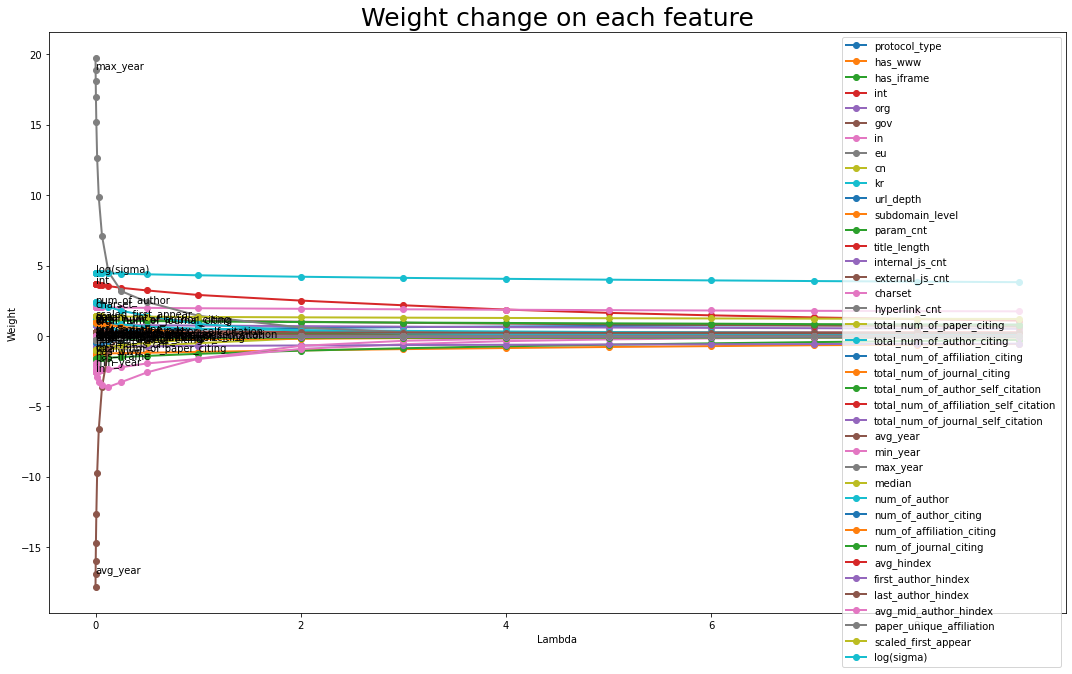

In [8]:
feature_names = [*x.columns, 'log(sigma)']

graph = plot_importance_trending(feature_names, performance_matrix.drop('intercept', axis=1), 'Weight change on each feature', 1)

display(graph)


<module 'matplotlib.pyplot' from '/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

<Figure size 432x288 with 0 Axes>

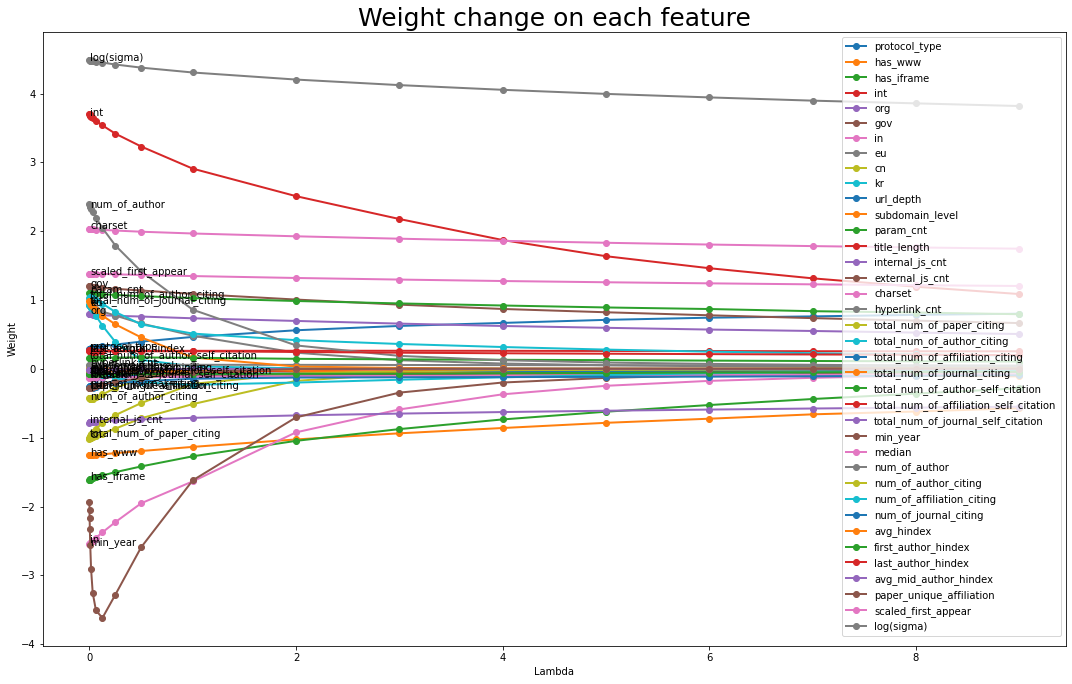

In [9]:
feature_names = [*x.drop(['max_year', 'avg_year'], axis=1).columns, 'log(sigma)']

graph = plot_importance_trending(feature_names, performance_matrix.drop('intercept', axis=1), 'Weight change on each feature', 4)

display(graph)


In [10]:
def plot_feature_importance(reg_coef, col_names, title):
    reg_coef = pd.Series(reg_coef, index=col_names)
    reg_coef = reg_coef.sort_values()
    matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
    reg_coef.plot(kind="barh",)
    plt.title(title, fontsize=15)


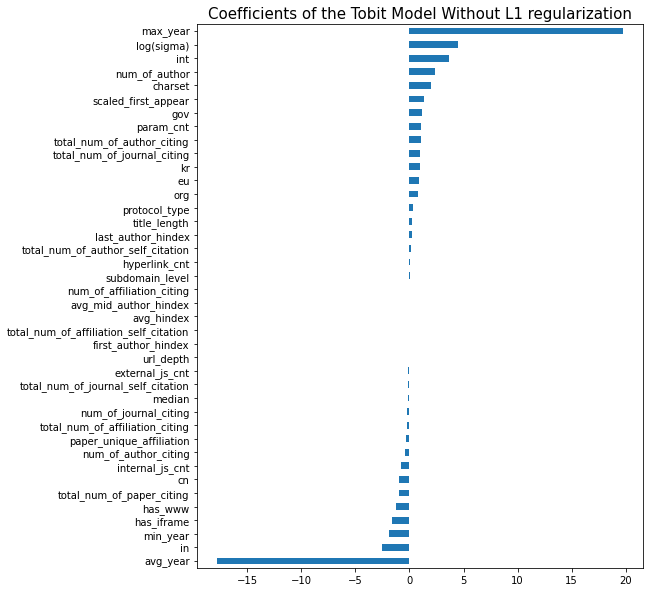

In [11]:
import matplotlib


feature_names = [*x.columns, 'log(sigma)']

# Get the model without any penalty term
coef = performance_matrix[performance_matrix['lambda'] == 0][feature_names].iloc[0,:]
plot_feature_importance(
    coef, feature_names, 
    "Coefficients of the Tobit Model Without L1 regularization")

In [12]:
from sklearn.metrics import mean_squared_error


def get_pseudo_r2(y_true, y_hat):
    correlation_matrix = np.corrcoef(y_true, y_hat)
    correlation_xy = correlation_matrix[0,1]
    return correlation_xy**2

def predict(feature_names, X, coef):
    X = X.copy()
    X.insert(0, 'intercept', 1.0)
    X = X.loc[:, ['intercept', *feature_names]]
    return X @ coef


def create_pseudo_r2_matrix(x, y):
    def _create_pseudo_r2_matrix(row):
        y_hat = predict(feature_names, x, row.loc[['intercept', *feature_names]])
        return get_pseudo_r2(y, y_hat)

    return _create_pseudo_r2_matrix

def create_mse_matrix(x, y):
    def _create_mse_matrix(row):
        y_hat = predict(feature_names, x, row.loc[['intercept', *feature_names]])
        return math.sqrt(mean_squared_error(y, y_hat))

    return _create_mse_matrix


feature_names = x.columns
coef = performance_matrix[performance_matrix['lambda'] == 0][['intercept', *feature_names]].iloc[0,:]


r2_train = get_pseudo_r2(y_train, predict(feature_names, X_train, coef))
r2_test = get_pseudo_r2(y_test, predict(feature_names, X_test, coef))



print(f'Pseudo R square on training set: %.2f%%' % (r2_train * 100))
print(f'Pseudo R square on testing set: %.2f%%' % (r2_test * 100))

# Create {prediction}/{pseudo r2}/{residual} for training and testing set
performance_matrix.loc[:, 'pseudo_r2_train'] = performance_matrix.apply(create_pseudo_r2_matrix(X_train, y_train), axis=1)
performance_matrix.loc[:, 'rmse_train'] = performance_matrix.apply(create_mse_matrix(X_train, y_train), axis=1)
performance_matrix.loc[:, 'pseudo_r2_test'] = performance_matrix.apply(create_pseudo_r2_matrix(X_test, y_test), axis=1)
performance_matrix.loc[:, 'rmse_test'] = performance_matrix.apply(create_mse_matrix(X_test, y_test), axis=1)


Pseudo R square on training set: 10.89%
Pseudo R square on testing set: 6.94%


In [13]:
performance_matrix.columns

Index(['lambda', 'alpha', 'intercept', 'protocol_type', 'has_www',
       'has_iframe', 'int', 'org', 'gov', 'in', 'eu', 'cn', 'kr', 'url_depth',
       'subdomain_level', 'param_cnt', 'title_length', 'internal_js_cnt',
       'external_js_cnt', 'charset', 'hyperlink_cnt',
       'total_num_of_paper_citing', 'total_num_of_author_citing',
       'total_num_of_affiliation_citing', 'total_num_of_journal_citing',
       'total_num_of_author_self_citation',
       'total_num_of_affiliation_self_citation',
       'total_num_of_journal_self_citation', 'avg_year', 'min_year',
       'max_year', 'median', 'num_of_author', 'num_of_author_citing',
       'num_of_affiliation_citing', 'num_of_journal_citing', 'avg_hindex',
       'first_author_hindex', 'last_author_hindex', 'avg_mid_author_hindex',
       'paper_unique_affiliation', 'scaled_first_appear', 'log(sigma)',
       'pseudo_r2_train', 'rmse_train', 'pseudo_r2_test', 'rmse_test'],
      dtype='object')

In [14]:
def plot_performance(data,
                        legend_type_name,
                        x_axis_name,
                        upper_y_label,
                        lower_y_label,
                        title):
    plt.clf()
    f, ax = plt.subplots(2, 1, figsize=(15,8))
    legends = data[legend_type_name].unique()
    for idx, legend in enumerate(legends):
        _data = data[data[legend_type_name]==legend]
        ax[0].plot(_data[x_axis_name], _data[upper_y_label], linewidth=2, label=f'{legend_type_name}: {legend}')
        ax[0].set_xlabel(x_axis_name, fontsize=15)
        ax[0].set_ylabel(upper_y_label.upper(), fontsize=15)
        ax[0].legend(fontsize=10, loc='upper right')

        ax[1].plot(_data[x_axis_name], _data[lower_y_label], linewidth=2, label=f'{legend_type_name}: {legend}')
        ax[1].set_xlabel(x_axis_name, fontsize=15)
        ax[1].set_ylabel(lower_y_label.upper(), fontsize=15)
        ax[1].legend(fontsize=10, loc='lower right')

    ax[0].set_title(f"Performance Evaluation of {title}", fontsize=24)
    plt.tight_layout()

    plt.show()
    return plt


<Figure size 576x720 with 0 Axes>

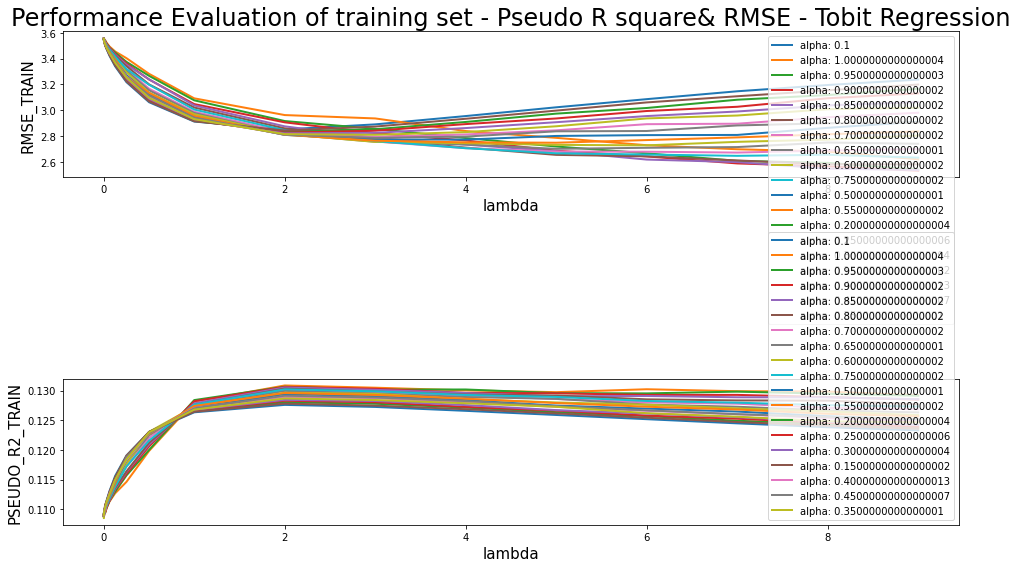

<module 'matplotlib.pyplot' from '/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [15]:
plot_performance(data=performance_matrix,
                    legend_type_name='alpha',
                    x_axis_name='lambda',
                    upper_y_label='rmse_train',
                    lower_y_label='pseudo_r2_train',
                    title='training set - Pseudo R square& RMSE - Tobit Regression'
)

<Figure size 576x720 with 0 Axes>

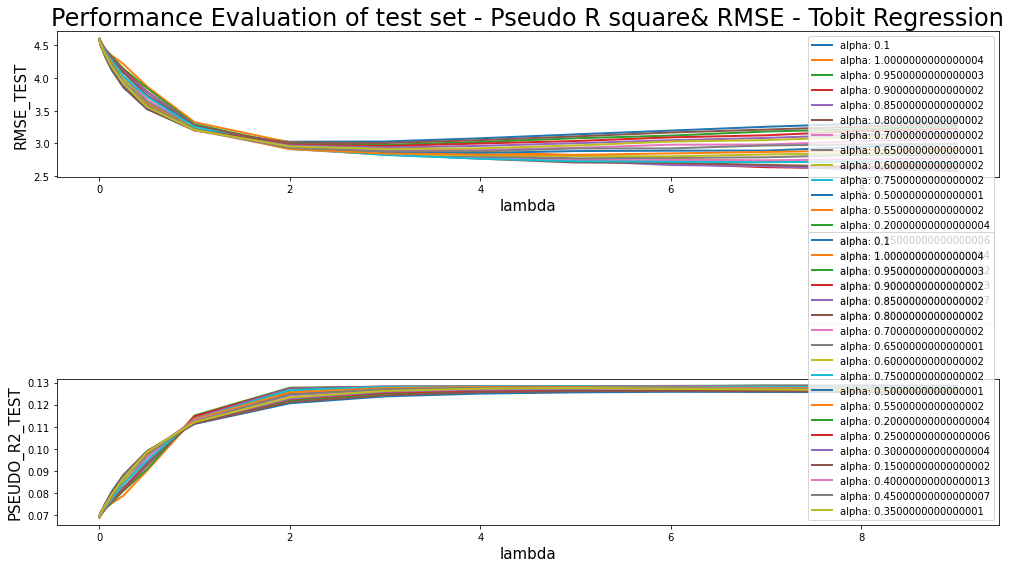

<module 'matplotlib.pyplot' from '/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [16]:
plot_performance(data=performance_matrix,
                    legend_type_name='alpha',
                    x_axis_name='lambda',
                    upper_y_label='rmse_test',
                    lower_y_label='pseudo_r2_test',
                    title='test set - Pseudo R square& RMSE - Tobit Regression'
)

In [17]:
def plot_comparsion(data,
                        legend_type_name,
                        x_axis_name,
                        label1,
                        label2,
                        label_name,
                        title):
    plt.clf()
    plt.figure(figsize=(15, 5))
    comparsion_matrix = data.groupby([x_axis_name]).agg(['mean'])[[label1, label2]]
    comparsion_matrix.columns = [label1, label2]
    comparsion_matrix.loc[:, x_axis_name] = comparsion_matrix.index.tolist()
    comparsion_matrix.reset_index(drop=True, inplace=True)
    
    x_lab = x_axis_name
    y_lab = label_name
    for label in [label1, label2]:
        plt.plot(comparsion_matrix[x_axis_name], comparsion_matrix[label], 'o-', linewidth=2, label=label)
    plt.title(title, fontSize=25)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)

    plt.legend(fontsize=15, loc='best')
    plt.tight_layout()

    plt.show()
    return plt


<Figure size 576x720 with 0 Axes>

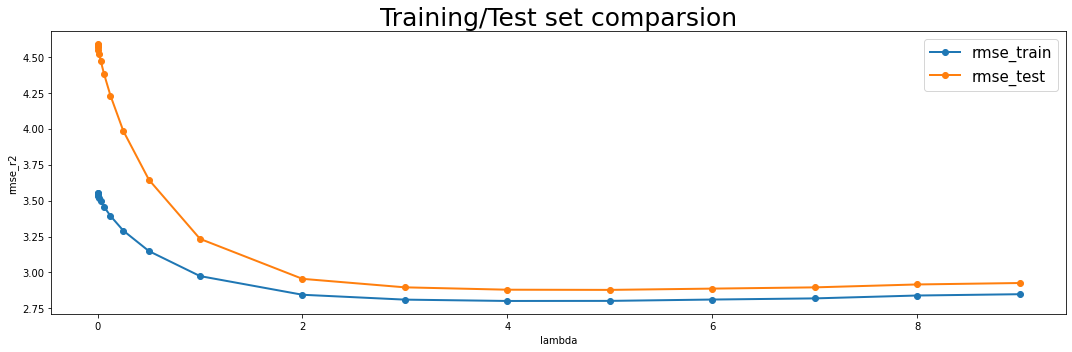

<module 'matplotlib.pyplot' from '/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [18]:
plot_comparsion(performance_matrix, 'alpha', 'lambda',
                'rmse_train', 'rmse_test', 'rmse_r2',
                'Training/Test set comparsion')


<Figure size 576x720 with 0 Axes>

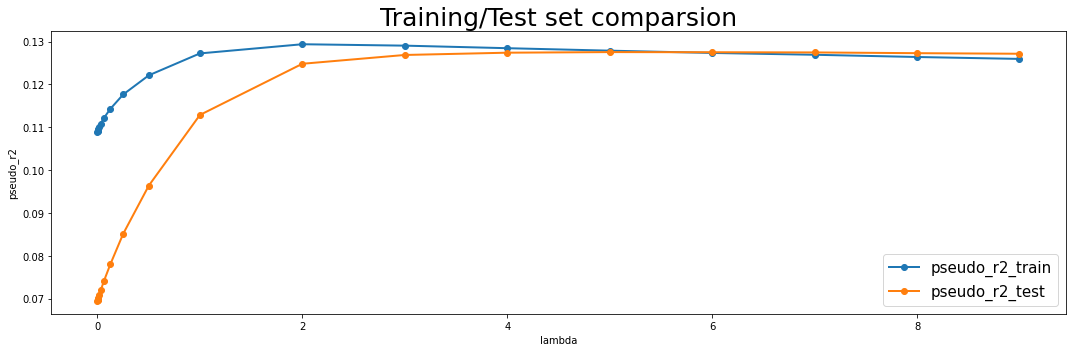

<module 'matplotlib.pyplot' from '/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [19]:
plot_comparsion(performance_matrix, 'alpha', 'lambda',
                'pseudo_r2_train', 'pseudo_r2_test', 'pseudo_r2',
                'Training/Test set comparsion')


In [20]:
get_pseudo_r2(y, pd.Series([p_censor_right] * len(y)))

5.856421279529152e-32